# Computational scheme for the free energy of a simplicial complex
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Introduction**
In this notebook, we compute the Free energy of a simplicial complex from a given dataset. First we analyse the dataset to define a connection probability. After this, we can choose a desired simplicial complex G_i from the set with $0<i<N$ complexes and compute the internal energy U and the entropy S, according to Knill's work. From this we can then compute the Helmholtz free energy F.

**Import libraries**

In [2]:
# Basic data manipulation libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import timeit
import os

**Import the dataset**

In [9]:
# For now just give a pre-set dataset
import openpyxl
import numpy as np

# Specify the directory and file name
excel_file_path = r'C:\Users\cyril\OneDrive\Documenten\MSc Physics and Astronomy\Thesis\Planning\Week 9 - 18 jan\Dataset_example\SimplicialComplex_G.xlsx'

# Load the Excel file into a Pandas DataFrame
G_list = []
sheet_list = ['G_A', 'G_B', 'G_C', 'G_D', 'G_E', 'G_F']
for sheet in sheet_list:
    df = pd.read_excel(excel_file_path, sheet_name=sheet, engine='openpyxl', header=None)
    G_i = df.values.astype(np.float64)
    G_i = np.nan_to_num(G_i, nan=0)
    G_list.append(G_i)

# Now, G is a 2D NumPy array containing the data from the first sheet of the Excel file
G = np.array(G_list)

**Binarization**

Knill reports the connection matrix as binary, so L_xy = 1 if the simplex x intersects with the simplex y and L_xy = 0 if it doesn’t. So there is no degree in connectivity. Binarize the matrices in further calculations for now, to first work out the method according to Knill, without connectivity degree.

In [10]:
threshold = 0.0
G_binary = (G > threshold).astype(int)

**Draw the simplicial complexes from the dataset**

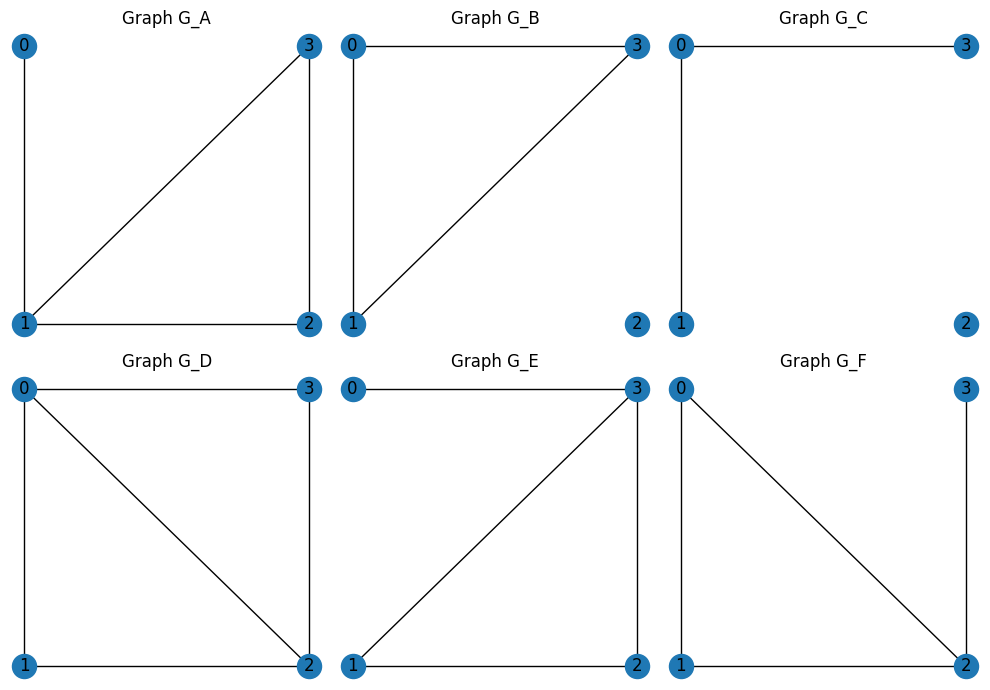

In [11]:
import networkx as nx 
import numpy as np 
import matplotlib.pyplot as plt

def create_subarray(original_array):
    # Extract the subarray from the first 4 rows and first 4 columns
    subarray = [row[:4] for row in original_array[:4]]
    return subarray

G_test_list = []

for i in range(0, len(G)):
    G_test = create_subarray(G_binary[i])
    G_test_list.append(np.array(G_test))

fixed_pos = {0: (0, 1), 1: (0, 0), 2: (1, 0), 3: (1, 1)}

# Create a single figure with subplots
plt.figure(figsize=(10, 7))  # Adjust the figure size as needed
plt.title('Visualisation of the complete dataset')

for i, graph_matrix in enumerate(G_test_list):
    plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns, current plot index
    G_drawing = nx.from_numpy_matrix(graph_matrix)
    nx.draw(G_drawing, with_labels=True, pos=fixed_pos)
    plt.title(f'Graph {sheet_list[i]}')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

**Compute the connection probability matrix $L_p$**

In [12]:
L_p = np.mean(G_binary, axis=0)

**Compute the inverse connection matrix ${L_i}^{-1}$**

To do this we first have to get rid of the zero rows and column, since the matrix is not invertible if the determinant of the desired matrix is zero. When we did this we can generate the inverted matrix. So for example for the first matrix L_A this would go like:

In [13]:
def inverse_matrix_generator(matrix):

    # Find non-zero rows and columns
    non_zero_rows = ~np.all(matrix == 0, axis=1)

    # Store the indices of removed rows. This is the same for the columns since the matrices are symmetric
    removed_rows = np.where(~non_zero_rows)[0].tolist()

    # Extract the non-zero rows and columns
    result_matrix = matrix[non_zero_rows][:, non_zero_rows]

    # Generate inverse matrix
    if np.linalg.det(result_matrix) != 0:
        inverse_matrix_unrounded = np.linalg.inv(result_matrix)
        inverse_matrix = np.round(inverse_matrix_unrounded, decimals=2)
    else:
        inverse_matrix = 0

    return result_matrix, removed_rows, inverse_matrix

In [34]:
# Customize print settings to print the entire matrix
#np.set_printoptions(threshold=np.inf)
# Reset NumPy print options to the default settings
#np.set_printoptions(threshold=1000)

In [14]:
# Generate desired matrix
matrix = G[0]

print("Original Matrix:")
print(matrix)

Original Matrix:
[[1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 2. 1. 0. 0. 0. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 2. 0. 0. 0. 1. 0. 0.]
 [0. 1. 1. 1. 1. 2. 1. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 1. 3. 1. 2. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 2. 1. 3. 1. 1. 0. 0. 0. 3. 0. 0.]
 [0. 2. 1. 1. 2. 1. 3. 1. 0. 0. 0. 3. 0. 0.]
 [1. 1. 2. 1. 1. 1. 1. 3. 0. 0. 0. 3. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 3. 3. 3. 0. 0. 0. 6. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [15]:
# Generate matrix without zero rows and columns
result_matrix, removed_rows, inverse_matrix = inverse_matrix_generator(matrix)

print("\nMatrix without Zero Rows and Columns:")
print(result_matrix)

print("\nIndices of Removed Rows/Columns:", removed_rows)


Matrix without Zero Rows and Columns:
[[1. 1. 0. 0. 1. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 2. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 2. 1.]
 [0. 1. 1. 1. 1. 2. 1. 1. 1.]
 [1. 1. 1. 1. 3. 1. 2. 1. 1.]
 [1. 1. 1. 2. 1. 3. 1. 1. 3.]
 [0. 2. 1. 1. 2. 1. 3. 1. 3.]
 [1. 1. 2. 1. 1. 1. 1. 3. 3.]
 [1. 1. 1. 1. 1. 3. 3. 3. 6.]]

Indices of Removed Rows/Columns: [8, 9, 10, 12, 13]


In [16]:
# Generate the inverse matrix
if np.linalg.det(result_matrix) != 0:
    print("Inverse Matrix:")
    print(inverse_matrix)
else:
    print("The matrix is singular and cannot be inverted.")

Inverse Matrix:
[[ 0.29  0.56 -0.31 -0.31  0.    0.1  -0.19  0.1  -0.04]
 [ 0.56  0.21  0.04  0.04 -0.5   0.02  0.46  0.02 -0.31]
 [-0.31  0.04 -1.04  0.96  0.   -0.27  0.04  0.73 -0.19]
 [-0.31  0.04  0.96 -1.04  0.    0.73  0.04 -0.27 -0.19]
 [-0.   -0.5   0.    0.    0.5  -0.   -0.   -0.   -0.  ]
 [ 0.1   0.02 -0.27  0.73  0.   -0.13 -0.23 -0.13  0.15]
 [-0.19  0.46  0.04  0.04 -0.   -0.23 -0.04 -0.23  0.19]
 [ 0.1   0.02  0.73 -0.27  0.   -0.13 -0.23 -0.13  0.15]
 [-0.04 -0.31 -0.19 -0.19 -0.    0.15  0.19  0.15  0.04]]


Repeat this for the complete dataset, so that we end up with inverse matrices for $G_A$ to $G_F$

In [17]:
L_inverse_list = []
removed_rows_list = []

for matrix in G:
    result_matrix, removed_rows, inverse_matrix = inverse_matrix_generator(matrix)
    L_inverse_list.append(inverse_matrix)
    removed_rows_list.append(removed_rows)

Try to decompress the inverse matrices for later use, since we need to multiple them with the $L_p$ matrix and thus should be of equal dimensions.
However, decompressing is not that easy, because the stored indexation of the removed rows and columns is not the same as the place we should return zero rows and columns. To do this, below, we first decompressed the first row of the ${L_i}^{-1}$ matrix by inserting zeros at the indices of the removed columns. This decompressed row list then presents the location where zero columns (and rows due to symmetry) should be inserted into the ${L_i}^{-1}$ matrix. This happens in the next step, using the function add_zero_array for each zero value in the decompressed row list.

In [18]:
# Define function to decompress the compressed array with inserting zeros at the indices of the removed rows and columns
def decompress_row(array_length, index_removed):
    
    # Add +1 to each value in the index_list since the count starts at zero
    index_removed = [x + 1 for x in index_removed]
    
    # Create an array of the indices present in the compressed array and a zero list
    array_compressed = [item for item in range(0, array_length) if item not in index_removed]
    zero_list = [0]*array_length

    # Replace the indices from the compressed array in the zero list
    for index in array_compressed:
        zero_list[index-1]=index
    
    # Set the adjusted zero list to be the new decompressed 1D array
    array_decompressed = zero_list

    return array_decompressed

In [19]:
# Add a zero column at the desired index
def add_zero_array(original_array, index, axis_choice):
    
    # Create a zero array of fitting shape
    zero_array = np.zeros(original_array.shape[0], dtype=original_array.dtype)

    # Insert the array into the original array
    inserted_array = np.insert(original_array, index, zero_array, axis=axis_choice)

    return inserted_array

In [20]:
def decompress(matrix, array_length, removed_rows):
    
    # Decompress the 1D array
    decompressed_1D_array = decompress_row(array_length, removed_rows)

    # Insert zero rows/columns at the indices with value zero from the decompressed 1D array
    for index in range(0, len(decompressed_1D_array)):
        if decompressed_1D_array[index] == 0:
            inserted_column_array = add_zero_array(matrix, index, 0) # The column axis is 0
            inserted_row_array = add_zero_array(inserted_column_array, index, 1) # The row axis is 1
            matrix = inserted_row_array
    return matrix

Let's test the decompression on for example the fifth inverse matrix ${L_5}^{-1}$:

In [21]:
print("Complete decompressed 2D array:")
print(decompress(L_inverse_list[4], 14, removed_rows_list[0]))

Complete decompressed 2D array:
[[ 0.   0.5  0.5  0.5 -0.5 -0.5 -0.5 -0.   0.   0.   0.   0.5  0.   0. ]
 [ 0.5 -1.3 -0.3  0.2 -0.1  1.4  0.4 -0.   0.   0.   0.  -0.7  0.   0. ]
 [ 0.5 -0.3 -1.3  0.2 -0.1  0.4  1.4  0.   0.   0.   0.  -0.7  0.   0. ]
 [ 0.5  0.2  0.2  0.2  0.4 -0.1 -0.1 -0.5  0.   0.   0.  -0.2  0.   0. ]
 [-0.5 -0.1 -0.1  0.4  0.3 -0.2 -0.2 -0.   0.   0.   0.   0.1  0.   0. ]
 [-0.5  1.4  0.4 -0.1 -0.2 -0.7 -0.7  0.   0.   0.   0.   0.6  0.   0. ]
 [-0.5  0.4  1.4 -0.1 -0.2 -0.7 -0.7 -0.   0.   0.   0.   0.6  0.   0. ]
 [-0.  -0.  -0.  -0.5 -0.  -0.  -0.   0.5  0.   0.   0.  -0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.5 -0.7 -0.7 -0.2  0.1  0.6  0.6  0.   0.   0.   0.  -0.3  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0

Again, repeat this for the complete dataset, so that we end up with decompressed inverse matrices for $G_A$ to $G_F$.

In [22]:
L_inverse_decompressed_list = []

for matrix in range(0, len(L_inverse_list)):
    decompressed_matrix = decompress(L_inverse_list[matrix], 14, removed_rows_list[matrix])
    L_inverse_decompressed_list.append(decompressed_matrix)

print(L_inverse_decompressed_list[4])

[[ 0.   0.5  0.5  0.5  0.  -0.5 -0.5 -0.5  0.  -0.   0.   0.5  0.   0. ]
 [ 0.5 -1.3 -0.3  0.2  0.  -0.1  1.4  0.4  0.  -0.   0.  -0.7  0.   0. ]
 [ 0.5 -0.3 -1.3  0.2  0.  -0.1  0.4  1.4  0.   0.   0.  -0.7  0.   0. ]
 [ 0.5  0.2  0.2  0.2  0.   0.4 -0.1 -0.1  0.  -0.5  0.  -0.2  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [-0.5 -0.1 -0.1  0.4  0.   0.3 -0.2 -0.2  0.  -0.   0.   0.1  0.   0. ]
 [-0.5  1.4  0.4 -0.1  0.  -0.2 -0.7 -0.7  0.   0.   0.   0.6  0.   0. ]
 [-0.5  0.4  1.4 -0.1  0.  -0.2 -0.7 -0.7  0.  -0.   0.   0.6  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [-0.  -0.  -0.  -0.5  0.  -0.  -0.  -0.   0.   0.5  0.  -0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.5 -0.7 -0.7 -0.2  0.   0.1  0.6  0.6  0.   0.   0.  -0.3  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 

**Calculate the internal energy U**

To calculate the internal energy of any desired simplicial complex $G_i$ from the dataset, we need to multiply the decompressed inverse matrix ${L_i}^{-1}$ with the connection probability matrix we calculated before $L_p$. I.e. the calculation is as follows:

$$
U(p) = \sum_{x,y} \left( {L_i}^{-1} \cdot L_p \right)
$$

Test this for the fifth simplicial complex in the dataset $G_5$.

In [23]:
def internal_energy(inverse_connection_matrix, probability_matrix):

    # Compute the internal energy
    U = np.sum(inverse_connection_matrix * probability_matrix)
    return U

In [24]:
U_G5 = internal_energy(L_inverse_decompressed_list[4], L_p)
print('The internal energy of G_5 is:', U_G5)

The internal energy of G_5 is: 0.316666666666666


**Calculate the entropy S**

To calculate the entropy S of any desired simplicial complex $G_i$ from the dataset, we need to use the diagonal of the probability matrix $L_p$ as follows:

$$
S(p) = - \sum_{x} p(x) \cdot log \left[ p(x) \right]
$$

Test this for the fifth simplicial complex in the dataset $G_5$.

In [25]:
def entropy(connection_matrix, probability_matrix):

    # Generate probability matrix specific to the simplicial complex G_i
    specific_probability_matrix = connection_matrix * probability_matrix

    # Extract the diagonal values as a list
    diagonal = np.round(np.diag(specific_probability_matrix).tolist(), decimals=2)

    non_zero_diagonal = [value for value in diagonal if value != 0]

    # Compute the entropy
    S = - np.sum(non_zero_diagonal * np.log(non_zero_diagonal))
    
    return S

In [26]:
S_G5 = entropy(G[4], L_p)
print('The entropy of G_5 is:', S_G5)

The entropy of G_5 is: -6.153375106641809


**Calculate the Helmholtz free energy F**

From the entropy S and the internal energy U that we just found, we can compute the Helmholtz free energy F using the relationship:

$$
F = U - T \cdot S
$$

Where we choose a fixed value for T, since we assume that the temperature is constant for all simplicial complexes in the dataset. Let's take the temperature to be T = 293 K. Again, test the formula for the the fifth simplicial complex $G_5$.

In [27]:
def free_energy(internal_energy, temperature, entropy):
    return internal_energy - temperature*entropy

In [28]:
T = 293
F_G5 = free_energy(U_G5, T, S_G5)
print('The Helmholtz free energy of G_5 is:', F_G5)

The Helmholtz free energy of G_5 is: 1803.2555729127166
